In [ ]:
# ==================== 导入必要的库 ====================
# %matplotlib inline: 在Jupyter中内嵌显示matplotlib图像
%matplotlib inline

# torch: PyTorch深度学习框架
import torch

# torchvision: PyTorch的计算机视觉库，包含预训练模型
import torchvision

# nn: PyTorch的神经网络模块
from torch import nn

# d2l: Dive into Deep Learning工具库
from d2l import torch as d2l

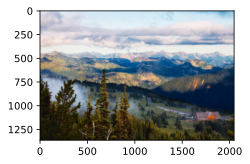

In [ ]:
# ==================== 加载内容图像 ====================
# 什么是样式迁移？
# - 将一张图片的艺术风格应用到另一张图片的内容上
# - 内容图像：提供场景和物体的图像
# - 样式图像：提供艺术风格的图像

# 设置图像显示大小
d2l.set_figsize()

# 加载内容图像（雷尼尔山的照片）
# 这张图提供"内容"，即场景中的物体和结构
content_img = d2l.Image.open('./img/rainier.jpg')

# 显示内容图像
d2l.plt.imshow(content_img);

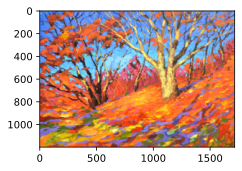

In [ ]:
# ==================== 加载样式图像 ====================

# 加载样式图像（秋天橡树的绘画）
# 这张图提供"样式"，即艺术风格、颜色、笔触等
style_img = d2l.Image.open('./img/autumn-oak.jpg')

# 显示样式图像
# 目标：将这张画的艺术风格应用到雷尼尔山的照片上
d2l.plt.imshow(style_img);

In [ ]:
# ==================== 图像预处理和后处理 ====================

# ImageNet数据集的RGB通道均值
# 用于归一化，这是VGG模型训练时使用的标准值
rgb_mean = torch.tensor([0.485, 0.456, 0.406])

# ImageNet数据集的RGB通道标准差
rgb_std = torch.tensor([0.229, 0.224, 0.225])


def preprocess(img, image_shape):
    """
    预处理图像，使其适合输入到VGG网络
    
    参数:
        img: PIL图像对象
        image_shape: 目标图像尺寸(height, width)
    
    返回:
        预处理后的张量，形状(1, 3, H, W)
    
    处理步骤：
    1. 调整图像大小
    2. 转换为张量（值域从[0,255]变为[0,1]）
    3. 归一化（使用ImageNet的均值和标准差）
    4. 添加批次维度
    """
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),           # 调整大小
        torchvision.transforms.ToTensor(),                    # 转为张量
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])  # 归一化
    return transforms(img).unsqueeze(0)  # 添加批次维度


def postprocess(img):
    """
    后处理图像，将张量转换回可显示的PIL图像
    
    参数:
        img: 图像张量，形状(1, 3, H, W)
    
    返回:
        PIL图像对象
    
    处理步骤：
    1. 移除批次维度
    2. 反归一化（还原到[0,1]范围）
    3. 裁剪到[0,1]范围（防止溢出）
    4. 转换为PIL图像
    """
    # 移除批次维度并移到正确的设备
    img = img[0].to(rgb_std.device)
    
    # 反归一化：img = img * std + mean
    # permute(1, 2, 0): (C, H, W) -> (H, W, C)
    # clamp: 确保像素值在[0, 1]范围内
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    
    # 转换回(C, H, W)格式，然后转为PIL图像
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [ ]:
# ==================== 构建特征提取网络 ====================

# 加载预训练的VGG-19模型
# VGG-19在图像分类任务上训练，其中间层能捕捉不同级别的特征
pretrained_net = torchvision.models.vgg19(pretrained=True)

# 定义用于提取样式和内容的层
# style_layers: 多个浅层和深层，捕捉不同尺度的纹理和模式
# content_layers: 深层，捕捉高级语义内容
# 
# 为什么选择这些层？
# - 浅层捕捉细节纹理（样式）
# - 深层捕捉语义内容（物体轮廓）
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

# 构建特征提取网络
# 只保留VGG的features部分（卷积层），去掉分类器
# 只保留到最深的样式层或内容层
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])


def extract_features(X, content_layers, style_layers):
    """
    从指定层提取特征
    
    参数:
        X: 输入图像张量
        content_layers: 内容层索引列表
        style_layers: 样式层索引列表
    
    返回:
        contents: 内容层的特征列表
        styles: 样式层的特征列表
    """
    contents = []  # 存储内容特征
    styles = []    # 存储样式特征
    
    # 逐层前向传播
    for i in range(len(net)):
        X = net[i](X)
        
        # 如果是样式层，保存特征
        if i in style_layers:
            styles.append(X)
        
        # 如果是内容层，保存特征
        if i in content_layers:
            contents.append(X)
    
    return contents, styles


def get_contents(image_shape, device):
    """
    提取内容图像的特征
    
    参数:
        image_shape: 目标图像尺寸
        device: 计算设备(CPU/GPU)
    
    返回:
        content_X: 预处理后的内容图像
        contents_Y: 内容图像在内容层的特征
    """
    # 预处理内容图像并移到指定设备
    content_X = preprocess(content_img, image_shape).to(device)
    
    # 提取内容特征（只需要内容层的输出）
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    
    return content_X, contents_Y


def get_styles(image_shape, device):
    """
    提取样式图像的特征
    
    参数:
        image_shape: 目标图像尺寸
        device: 计算设备(CPU/GPU)
    
    返回:
        style_X: 预处理后的样式图像
        styles_Y: 样式图像在样式层的特征
    """
    # 预处理样式图像并移到指定设备
    style_X = preprocess(style_img, image_shape).to(device)
    
    # 提取样式特征（只需要样式层的输出）
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    
    return style_X, styles_Y

/home/ymj68520/miniconda3/envs/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ymj68520/miniconda3/envs/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/ymj68520/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:26<00:00, 21.5MB/s] 


In [ ]:
# ==================== 定义损失函数 ====================

def content_loss(Y_hat, Y):
    """
    内容损失：衡量生成图像与内容图像的内容差异
    
    参数:
        Y_hat: 生成图像在内容层的特征
        Y: 内容图像在内容层的特征
    
    返回:
        内容损失值
    
    原理：
    - 使用均方误差(MSE)衡量特征的差异
    - detach()：将Y从计算图中分离，Y被视为常数
    - 内容损失越小，生成图像的内容越接近内容图像
    """
    # 从动态计算梯度的树中分离目标
    # 这是一个规定的值，而不是一个变量
    return torch.square(Y_hat - Y.detach()).mean()


def gram(X):
    """
    计算Gram矩阵（格拉姆矩阵）
    
    参数:
        X: 特征张量，形状(batch, channels, height, width)
    
    返回:
        Gram矩阵，形状(channels, channels)
    
    Gram矩阵的作用：
    - 捕捉特征之间的相关性
    - 表示图像的纹理和样式信息
    - 去除了空间位置信息，只保留样式统计特性
    
    计算方法：
    - 将特征图展平为(channels, height*width)
    - 计算 X * X^T，得到通道间的相关性矩阵
    """
    # 获取通道数和每个通道的元素总数
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    
    # 将(batch, channels, H, W)重塑为(channels, H*W)
    X = X.reshape((num_channels, n))
    
    # 计算Gram矩阵：X @ X^T
    # 归一化：除以(channels * n)，使其与图像大小无关
    return torch.matmul(X, X.T) / (num_channels * n)


def style_loss(Y_hat, gram_Y):
    """
    样式损失：衡量生成图像与样式图像的样式差异
    
    参数:
        Y_hat: 生成图像在某个样式层的特征
        gram_Y: 样式图像在该层的Gram矩阵
    
    返回:
        样式损失值
    
    原理：
    - 比较Gram矩阵的差异来衡量样式的差异
    - Gram矩阵捕捉了纹理和样式的统计特性
    - 样式损失越小，生成图像的样式越接近样式图像
    """
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()


def tv_loss(Y_hat):
    """
    全变分损失(Total Variation Loss)
    
    参数:
        Y_hat: 生成的图像张量
    
    返回:
        全变分损失值
    
    作用：
    - 促进生成图像的平滑性
    - 减少噪声和像素间的剧烈变化
    - 让生成的图像看起来更自然
    
    计算方法：
    - 计算相邻像素间的差异
    - 水平方向：Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]
    - 垂直方向：Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]
    - 对所有差异的绝对值求平均
    """
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [ ]:
# ==================== 定义损失权重和总损失函数 ====================

# 损失函数的权重
# content_weight: 内容损失的权重，控制保留多少原始内容
# style_weight: 样式损失的权重，控制应用多少样式（通常设得较大）
# tv_weight: 全变分损失的权重，控制图像平滑度
# 
# 权重调整指南：
# - 增大style_weight: 样式更明显，内容可能失真
# - 增大content_weight: 内容保留更好，样式可能不明显
# - 增大tv_weight: 图像更平滑，但可能丢失细节
content_weight, style_weight, tv_weight = 1, 1e3, 10


def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    """
    计算样式迁移的总损失
    
    参数:
        X: 生成的图像
        contents_Y_hat: 生成图像在内容层的特征
        styles_Y_hat: 生成图像在样式层的特征
        contents_Y: 内容图像在内容层的特征（目标）
        styles_Y_gram: 样式图像在样式层的Gram矩阵（目标）
    
    返回:
        contents_l: 内容损失列表
        styles_l: 样式损失列表
        tv_l: 全变分损失
        l: 总损失
    
    总损失 = α*内容损失 + β*样式损失 + γ*全变分损失
    """
    # 计算每个内容层的内容损失
    # zip将生成图像和目标图像的特征配对
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    
    # 计算每个样式层的样式损失
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    
    # 计算全变分损失（平滑度损失）
    tv_l = tv_loss(X) * tv_weight
    
    # 对所有损失求和
    # 10 * styles_l: 进一步放大样式损失的影响
    l = sum(10 * styles_l + contents_l + [tv_l])
    
    return contents_l, styles_l, tv_l, l

In [ ]:
# ==================== 合成图像类和初始化 ====================

class SynthesizedImage(nn.Module):
    """
    合成图像类：将要优化的图像本身作为模型参数
    
    关键思想：
    - 在样式迁移中，我们不是训练网络权重
    - 而是优化图像本身的像素值
    - 将图像作为nn.Parameter，使其可以被优化器更新
    """
    
    def __init__(self, img_shape, **kwargs):
        """
        初始化合成图像
        
        参数:
            img_shape: 图像形状(batch, channels, height, width)
        """
        super(SynthesizedImage, self).__init__(**kwargs)
        
        # 将图像本身定义为可训练参数
        # 初始化为随机值（稍后会被内容图像覆盖）
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        """
        前向传播：直接返回图像参数
        """
        return self.weight


def get_inits(X, device, lr, styles_Y):
    """
    初始化合成图像、优化器和样式Gram矩阵
    
    参数:
        X: 初始图像（通常使用内容图像）
        device: 计算设备
        lr: 学习率
        styles_Y: 样式图像的特征
    
    返回:
        gen_img(): 初始化的合成图像
        styles_Y_gram: 样式图像的Gram矩阵列表
        trainer: 优化器
    
    初始化策略：
    - 从内容图像开始优化（而非随机图像）
    - 这样能更快收敛，且更好地保留内容
    """
    # 创建合成图像对象并移到指定设备
    gen_img = SynthesizedImage(X.shape).to(device)
    
    # 用内容图像初始化合成图像
    # 这样优化起点就是内容图像，只需添加样式
    gen_img.weight.data.copy_(X.data)
    
    # 创建优化器：Adam优化器
    # 注意：优化的是图像的像素值，不是网络权重
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    
    # 预计算样式图像的Gram矩阵
    # 这些是固定的目标，不需要重复计算
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    
    return gen_img(), styles_Y_gram, trainer

In [ ]:
# ==================== 训练函数 ====================

def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    """
    训练样式迁移模型（优化合成图像）
    
    参数:
        X: 初始图像（内容图像）
        contents_Y: 内容图像的目标特征
        styles_Y: 样式图像的特征
        device: 计算设备
        lr: 初始学习率
        num_epochs: 训练轮数
        lr_decay_epoch: 学习率衰减的epoch间隔
    
    返回:
        X: 优化后的合成图像
    
    训练过程：
    - 不是训练网络，而是优化图像本身
    - 每次迭代更新图像像素值
    - 使损失函数最小化，使图像同时保留内容和样式
    """
    # 初始化合成图像、样式Gram矩阵和优化器
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    
    # 创建学习率调度器
    # 每lr_decay_epoch个epoch，学习率乘以0.8
    # 学习率衰减有助于后期的精细调整
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    
    # 创建动画器，用于可视化训练过程
    # 显示内容损失、样式损失、全变分损失的变化
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    
    # 训练循环
    for epoch in range(num_epochs):
        # 清零梯度
        trainer.zero_grad()
        
        # 提取当前合成图像的内容和样式特征
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        
        # 计算所有损失
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        
        # 反向传播：计算梯度
        # 梯度是相对于图像像素值的
        l.backward()
        
        # 更新图像像素值
        # 优化器调整像素值以减少损失
        trainer.step()
        
        # 更新学习率
        scheduler.step()
        
        # 每10个epoch可视化一次
        if (epoch + 1) % 10 == 0:
            # 在右侧显示当前生成的图像
            animator.axes[1].imshow(postprocess(X))
            
            # 在左侧绘制损失曲线
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    
    return X

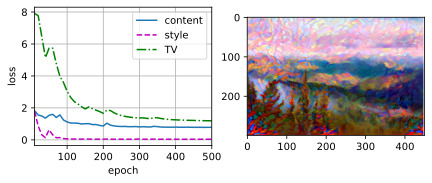

In [ ]:
# ==================== 执行样式迁移 ====================

# 设置计算设备和目标图像尺寸
device, image_shape = d2l.try_gpu(), (300, 450)

# 将特征提取网络移到GPU
net = net.to(device)

# 提取内容图像的特征
# content_X: 预处理后的内容图像
# contents_Y: 内容图像在内容层的特征（优化目标）
content_X, contents_Y = get_contents(image_shape, device)

# 提取样式图像的特征
# styles_Y: 样式图像在样式层的特征（优化目标）
_, styles_Y = get_styles(image_shape, device)

# 开始训练（优化合成图像）
# 参数说明：
# - content_X: 初始图像（从内容图像开始）
# - contents_Y: 内容目标特征
# - styles_Y: 样式目标特征
# - device: GPU设备
# - 0.3: 学习率
# - 500: 训练500个epoch
# - 50: 每50个epoch衰减一次学习率
# 
# 输出：
# - 左图：损失曲线（蓝色=内容损失，橙色=样式损失，绿色=全变分损失）
# - 右图：合成图像的演化过程
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)